In [4]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from collections import OrderedDict, Counter
import ConfigParser
import os
import glob
import json
import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def isNaN(num):
    return num != num

PERCENTILES = [0, 95, 99, 99.9]
HT = True

# The following numbers were gathered from kaarya-z840.
# Num Cores    = [0,  1,  2,  3,  4,  5,   6,   7,   8,   9,  10,  11,  12]
Bully_Progress = [0, 12, 29, 46, 65, 82, 104, 126, 140, 160, 180, 196, 216] # NO HT
Bully_Progress = [0,  0, 39, 56, 77, 99, 121, 146, 168, 190, 215, 236, 260] # With HT


In [5]:

class BufInfo:
    def BenchmarkKeyMetrics(self, f):
        p = pd.read_csv(f)
        s = p.sort_values(by="Key Metric Name").sort_values(by="Benchmark", ascending=False)
        return s
    
    def __init__(self, buf_dir, recompute = False, printAll = True):
        self.buf = os.path.basename(buf_dir)
        self.config = os.path.basename(os.path.dirname(buf_dir))
        
        files = glob.glob(buf_dir + "\\*\\BenchmarkKeyMetrics.csv")
        csv = pd.concat([self.BenchmarkKeyMetrics(f) for f in files], keys = range(len(files))).round(4)
        
        self.iters = 0
        for run_dir in [os.path.dirname(d) for d in glob.glob(buf_dir + "\\*\\")]:
            run_id = os.path.basename(run_dir)
            if printAll:
                print "{}\t{}\t{}\t\t{}".format(self.config, self.buf, run_id, list(csv.loc[int(run_id)]["Key Metric Value"]))
            self.iters += 1
        
        self.avg = OrderedDict()
        for b in list(csv.loc[0]["Key Metric Name"]):
            values = csv[csv["Key Metric Name"] == b]["Key Metric Value"]
            if b == "Progress":
                cores_harvested = (values-12)/16.0
                self.avg["harvestedcpu-avg"] = max(0, round(np.mean(cores_harvested), 2))
                self.avg["harvestedcpu-stddev"] = round(np.std(cores_harvested), 2)
            elif b == "Run time (second)" and 'HDInsight-1-0' in list(csv.loc[0]["VM Name"]):
                values = values-90 #substract 90sec init time
                self.avg[b+"-avg"] = round(np.mean(values), 2)
                self.avg[b+"-stddev"] = round(np.std(values), 2)
            elif b == "P99(ms)" and 'IndexServe-0-0' in list(csv.loc[0]["VM Name"]) and 'IndexServe-1-0' in list(csv.loc[0]["VM Name"]):
                values = csv[csv["VM Name"] == 'IndexServe-0-0']["Key Metric Value"]
                self.avg[b+"-0-avg"] = round(np.mean(values), 2)
                self.avg[b+"-0-stddev"] = round(np.std(values), 2)
                values = csv[csv["VM Name"] == 'IndexServe-1-0']["Key Metric Value"]
                self.avg[b+"-1-avg"] = round(np.mean(values), 2)
                self.avg[b+"-1-stddev"] = round(np.std(values), 2)
            else:
                self.avg[b+"-avg"] = round(np.mean(values), 2)
                self.avg[b+"-stddev"] = round(np.std(values), 2)
        

In [63]:
def process_directories(result_dir, recompute = False, printAll = True):
    #config = json.load(open(result_dir + "\\config.json"))
    #print config["LatSensitive"]["TracePath"]
    
    aggregate = "" 
    #if printAll:
    #    print "Config\t\tBuffer\tIter\t[P99, BullyThroughput]\tBullyCoresHarvested\tAffinity{}".format(AffinityHeader())

    bufInfos = OrderedDict()
    for mode_dir in [os.path.dirname(d) for d in glob.glob(result_dir + "\\*\\")]:
        config = "-".join(os.path.basename(mode_dir).split("-")[2:])
        bufInfos[config] = OrderedDict()
        for buf_dir in [os.path.dirname(d) for d in glob.glob(mode_dir + "\\Smart*CpuGroups*\\*\\")]:
           # print buf_dir
            buf_label = os.path.basename(buf_dir).split("-")[-1]
            bufInfo = BufInfo(buf_dir, recompute, False)
            bufInfos[config][buf_label] = bufInfo.avg

            aggregate += "{}\t{}\t{}\t{}\n".format(config, buf_label, bufInfo.iters, bufInfo.avg.values())
            
        aggregate += "\n"
    
    keys = bufInfo.avg.keys()
    aggregate_header = "\n\nAggregated results:\nConfig\t\tBuffer\tIters\t ["+ ", ".join(keys) +"]\n\n"
    if printAll:
        print aggregate_header
        print aggregate
    
    return (bufInfos, keys)


def plotLatencyProgress(data, keys, labels, fmts, title="", xlabel="", ylabel="", savePath=None, figName=None, errorBar=False, hlineIS=False, \
                        hlineMem=False, colors=None, runTime=0):
    plt.rcParams.update({'font.size': 13})
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc("axes", labelsize=20)
    plt.rc("axes", titlesize=22)
    fig, ax = plt.subplots(1,1)
    #plt.tight_layout()
    #ax.set_xlim(0,4)
    #ax.set_ylim(80,400)
    if hlineIS:
        ax.axhline(10, color='red', ls=':',lw=1)
        #ax.axhline(data[0].loc[keys[0]].values[0]+1, color='red', ls=':',lw=1)
    if hlineMem:
        ax.axhline(130, color='red', ls=':',lw=1)
    for i in range(len(data)):
        y_data = data[i].loc[keys[0]].values
        x_data = data[i].loc[keys[2]].values
        if runTime:
            x_data = runTime/x_data
        if not errorBar:
            if colors == None:
                plt.plot(x_data, y_data, fmts[i], label=labels[i], ms=10)
            else:
                plt.plot(x_data, y_data, fmts[i], label=labels[i], ms=10, c=colors[i])
            #plt.plot(cg.loc["Progress"].values, cg.loc["P99(us)"].values, 'rx-', label="CpuGroups")
        else:
            plt.errorbar(x_data, y_data, fmt=fmts[i], xerr=data[i].loc[keys[3]].values, yerr=data[i].loc[keys[1]].values, ecolor='black', capsize=2, label=labels[i])
            #plt.errorbar(cg.loc["Progress"].values, cg.loc["P99(us)"].values, fmt='rx-', xerr=cg.loc["Progressstddev"].values, yerr=cg.loc["P99(us)stddev"].values, ecolor='g', capsize=2, label="CpuGroups")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)#fig.suptitle(title)
    plt.legend()
    plt.tight_layout()
    if savePath is not None:
        plt.savefig(savePath)
        plt.savefig("figures-047\\"+figName)
    plt.show()
    
def plotLatencyProgressMultiple(data, keys, labels, fmts, title="", xlabel="", ylabels="", savePath=None, figName=None, subTitles=[], errorBar=False, hlineIS=False):
    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
    ax1.set_title(subTitles[0])
    ax1.set_ylabel(ylabels[0])
    ax2.set_title(subTitles[1])
    ax2.set_ylabel(ylabels[1])
    ax2.set_xlabel(xlabel)
    if hlineIS:
        ax1.axhline(10, color='red', ls=':',lw=1)
        ax2.axhline(10, color='red', ls=':',lw=1)
        #ax1.axhline(data[0].loc[keys[0]].values[0]+1, color='red', ls=':',lw=1)
        #ax2.axhline(data[0].loc[keys[2]].values[0]+1, color='red', ls=':', lw=1)
    for i in range(len(data)):
        ax1.plot(data[i].loc[keys[4]].values, data[i].loc[keys[0]].values, fmts[i], label=labels[i])
        ax2.plot(data[i].loc[keys[4]].values, data[i].loc[keys[2]].values, fmts[i], label=labels[i])

    #fig.suptitle(title)
    plt.legend()
    plt.autoscale()
    if savePath is not None:
        plt.savefig(savePath)
        plt.savefig("figures-047\\"+figName)
    plt.show()

def plotLatencyProgressList(datas, keys, labels, fmts, subtitles, title="", xlabel="", ylabel="", savePath=None, figName=None, subTitles=[], errorBar=False, hlineIS=False, hlineMem=False):
    n = len(datas)
    fig, axes = plt.subplots(1,n,sharex=True,sharey=True, figsize=(13,5), constrained_layout=True)
    ax=axes[0]
    ax.set_ylabel(ylabel)
    for j in xrange(n):
        ax = axes[j]
        ax.set_xlabel(xlabel)
        ax.set_title(subtitles[j])
        data = datas[j]
        if hlineIS:
            ax.axhline(10, color='red', ls=':',lw=1)
            #ax.axhline(datas[0][0].loc[keys[0]].values[0]+1, color='red', ls=':',lw=1)
        if hlineMem:
            ax.axhline(130, color='red', ls=':',lw=1)
        for i in range(len(data)):
            ax.plot(data[i].loc[keys[2]].values, data[i].loc[keys[0]].values, fmts[i], label=labels[i], ms=8)
    
    fig.suptitle(title)
    plt.legend()
    if savePath is not None:
        plt.savefig(savePath)
        plt.savefig("figures-047\\"+figName+".pdf")
        plt.savefig("figures-047\\"+figName+".png")
    plt.show()

c:\hvm\Results-atc\single_primary\index-bully\500qps
                         2     3     4     5     6     7
P99(ms)-avg          12.40  9.97  9.30  9.27  9.17  9.03
P99(ms)-stddev        0.30  0.09  0.00  0.09  0.09  0.05
harvestedcpu-avg      8.34  7.42  6.42  5.40  4.46  3.65
harvestedcpu-stddev   0.09  0.06  0.06  0.03  0.06  0.03


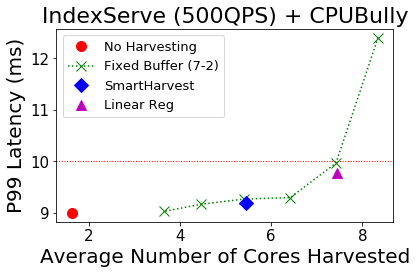

c:\hvm\Results-atc\single_primary\index-bully\1500qps


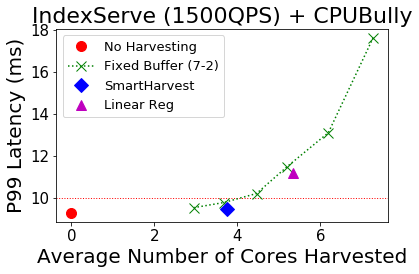

In [66]:
#======================================================================================================#   
# indexserve + cpubully
#======================================================================================================#  

result_dirs = sorted(glob.glob("results/500qps"))

title="IndexServe (500QPS) + CPUBully"
xlabel="Average Number of Cores Harvested"
ylabel="P99 Latency (ms)"

for PATH in result_dirs:
    print PATH
    bufInfo, keys = process_directories(PATH, True, False)
    print pd.DataFrame(bufInfo["fixed-buffer"])
    data = [pd.DataFrame(bufInfo["no-harvesting-5ms"]),
            pd.DataFrame(bufInfo["fixed-buffer"])[['2','3','4','5','6','7']],
            pd.DataFrame(bufInfo["learning-5-5ms"]),
            #pd.DataFrame(bufInfo["learning-4-5ms"]),
            pd.DataFrame(bufInfo["learning-1-5ms-reg"])
           ]

    labels = ["No Harvesting", "Fixed Buffer (7-2)", "SmartHarvest", "Linear Reg"]
    fmts   = ['ro', 'gx:', 'bD', 'm^'] 
    
    fig = "final\\is_500qps_bully.pdf"
    plotLatencyProgress(data, keys, labels, fmts, title, xlabel, ylabel, savePath = PATH+"\\fig.png", figName=fig, errorBar=False, hlineIS=True)
    